# Assessing metadata found in the Zenodo repository for datasets

**Aim.** The aim of this experiment is to evaluate if the RDF metadata published by [Zenodo](https://zenodo.org/) is following the FAIR principles guideline.

**Material and methods.** In this experiment, we launch a set of FAIR tests which are mostly based on SPARQL requests.

**Results.** We produce an UpSetPlot summarizing the number of resource validating each test, allowing to show some validation combination profiles.

In [1]:
import sys
parentdir = "../.."
sys.path.insert(0, parentdir)

import requests
from os import path
from tqdm.notebook import tqdm
import pandas as pd
import time

from metrics.WebResource import WebResource
from metrics.FAIRMetricsFactory import FAIRMetricsFactory
from metrics.AbstractFAIRMetrics import AbstractFAIRMetrics

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 101.0.4951
[WDM] - Get LATEST driver version for 101.0.4951
[WDM] - Driver [/Users/gaignard-a/.wdm/drivers/chromedriver/mac64/101.0.4951.41/chromedriver] found in cache


In [2]:
from rdflib import ConjunctiveGraph, Namespace, URIRef
from rdflib.namespace import RDF, RDFS

schema = Namespace("http://schema.org/")

## 1. Retrieve a list of DOIs from the Zenodo repository API

In [3]:
TIMEOUT = (10, 300)
#NB = 10000
NB = 10
TYPE = "dataset"
OUTPUT_DIR = "../results/zenodo_data/"

def zenodoRestRequest():
    print("REST request to zenodo...")
    # rest request
    url = 'https://zenodo.org/api/records/?sort=mostrecent&page=1&size=' + "7000"
    while True:
        try:
            response = requests.get(url, timeout=TIMEOUT)
            break
        except SSLError:
            time.sleep(5)
        except requests.exceptions.Timeout:
            time.sleep(5)

    return response

def zenodoJsonParser(response):
    print("Parsing result...")
    json_response = response.json()

    dois_list = []
    count = 1
    for element in json_response["hits"]["hits"]:
        type = element["metadata"]["resource_type"]["type"]
        if type == TYPE:
            if count > NB: break
            dois_list.append("https://doi.org/" + element["doi"])
            count += 1

    print("Retrieved " + str(len(dois_list)) + " DOIs")
    return dois_list

In [4]:
response = zenodoRestRequest()
dois_list = zenodoJsonParser(response)

REST request to zenodo...
Parsing result...
Retrieved 10 DOIs


## 2. Selecting a subset of the DOIs to create a sample

In [5]:
import random

random.seed(10)

samples_dois_list = random.sample(dois_list, NB)

splitedSize = 100
samples_chunks = [samples_dois_list[x:x+splitedSize] for x in range(0, len(samples_dois_list), splitedSize)]

In [6]:
print(len(samples_dois_list))

10


## 3. Initiating the list of metrics to be tested

In [7]:
metrics_collection = []
metrics_collection.append(FAIRMetricsFactory.get_F1A(None))
metrics_collection.append(FAIRMetricsFactory.get_F1B(None))
metrics_collection.append(FAIRMetricsFactory.get_F2A(None))
#metrics_collection.append(FAIRMetricsFactory.get_F2B_weak(None))
metrics_collection.append(FAIRMetricsFactory.get_I1(None))
# metrics_collection.append(FAIRMetricsFactory.get_I2(None))
metrics_collection.append(FAIRMetricsFactory.get_I3(None))
metrics_collection.append(FAIRMetricsFactory.get_R11(None))
metrics_collection.append(FAIRMetricsFactory.get_R12(None))
#metrics_collection.append(FAIRMetricsFactory.get_R13(None))

df_columns = ['ID']
for m in metrics_collection:
    #print(m.get_principle_tag())
    df_columns.append(m.get_principle_tag())

In [8]:
exec_time_df = pd.DataFrame(columns=df_columns)

def eval_metrics(web_res):
    metrics_collection = []
    metrics_collection.append(FAIRMetricsFactory.get_F1A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F1B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F2A(web_res))
#    metrics_collection.append(FAIRMetricsFactory.get_F2B_weak(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I1(web_res))
#     metrics_collection.append(FAIRMetricsFactory.get_I2(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I3(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R11(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R12(web_res))
#    metrics_collection.append(FAIRMetricsFactory.get_R13(web_res))
    
    row = {"ID":web_res.get_url()}
    row_time = {"ID":web_res.get_url()}
    for m in metrics_collection:
        ts1 = time.time()
        e = m.evaluate()
        duration = round((time.time() - ts1), 2)
        if e is not None:
            row[m.get_principle_tag()] = e.get_score()
            row_time[m.get_principle_tag()] = duration
    
    return row, row_time


## 4. Launching the list of FAIR tests for each DOI

In [9]:
def mass_eval(samples):
    evals = []
    exec_time = []

    for sample in tqdm(samples):
        wr = WebResource(url=sample)
        row, row_time = eval_metrics(wr)
        evals.append(row)
        exec_time.append(row_time)        
    
    return evals, exec_time

In [10]:
import logging
logging.getLogger().setLevel(logging.ERROR)

i = 0
for c in tqdm(samples_chunks):
    i += 1
    df = pd.DataFrame()
    df_time = pd.DataFrame()
    
    evals, exec_time = mass_eval(c)
    df = pd.concat([df, pd.DataFrame.from_records(evals)])
    df_time = pd.concat([df_time, pd.DataFrame.from_records(exec_time)])
    
    df.to_csv(OUTPUT_DIR + "FC_results_ZENODO_data_"+str(i)+".csv")
    df_time.to_csv(OUTPUT_DIR + "exec_time_ZENODO_data_"+str(i)+".csv")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

http://schema.org


INFO:a20eba57-714d-4f15-992a-69c25fc8831c:Checking if the URL is reachable, status code: 200
INFO:a20eba57-714d-4f15-992a-69c25fc8831c:Status code is OK, meaning the url is Unique.
INFO:d6d62629-85be-4975-8822-1fc853829a98:Strong evaluation:
INFO:d6d62629-85be-4975-8822-1fc853829a98:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d6d62629-85be-4975-8822-1fc853829a98:Found at least one of those property in metadata
INFO:e36a961f-9464-41e1-9871-638720c2cd4b:Checking if data is structured, looking for at least one RDF triple...
INFO:e36a961f-9464-41e1-9871-638720c2cd4b:161 RDF triples were found, thus data is in a well structured graph format
INFO:d3c15497-d425-4ff6-a43d-d02c1381c46b:Checking if data is structured, looking for at least one RDF triple...
INFO:d3c15497-d425-4ff6-a43d-d02c1381c46b:161 RDF triples were found, thus data is in a well structured graph format
INFO:9a3c1439-f21c-400d-98f1-fc0b0405b701:Checking that at least 3 different URL

https://schema.org/


INFO:bff0cf5d-711b-4e8a-87ce-4a0605f62959:Checking if the URL is reachable, status code: 200
INFO:bff0cf5d-711b-4e8a-87ce-4a0605f62959:Status code is OK, meaning the url is Unique.
INFO:e0b9e117-527d-4e86-bf23-fb1a69e58ba1:Strong evaluation:
INFO:e0b9e117-527d-4e86-bf23-fb1a69e58ba1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e0b9e117-527d-4e86-bf23-fb1a69e58ba1:Found at least one of those property in metadata
INFO:60486fb3-3e47-41da-8994-d10f371ced51:Checking if data is structured, looking for at least one RDF triple...
INFO:60486fb3-3e47-41da-8994-d10f371ced51:54 RDF triples were found, thus data is in a well structured graph format
INFO:60e74f0c-43a7-46bd-978e-d2997c814629:Checking if data is structured, looking for at least one RDF triple...
INFO:60e74f0c-43a7-46bd-978e-d2997c814629:54 RDF triples were found, thus data is in a well structured graph format
INFO:95b11268-1d5c-4a08-9cc8-79209e67589d:Checking that at least 3 different URL a

http://schema.org


INFO:46b87dec-23ea-43ae-b11a-142fd10b7d76:Checking if the URL is reachable, status code: 200
INFO:46b87dec-23ea-43ae-b11a-142fd10b7d76:Status code is OK, meaning the url is Unique.
INFO:99c221a8-6bc8-4808-b66d-c3ff2ab18594:Strong evaluation:
INFO:99c221a8-6bc8-4808-b66d-c3ff2ab18594:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:99c221a8-6bc8-4808-b66d-c3ff2ab18594:Found at least one of those property in metadata
INFO:62d36d8a-c799-45da-b416-51fbdb87e8e6:Checking if data is structured, looking for at least one RDF triple...
INFO:62d36d8a-c799-45da-b416-51fbdb87e8e6:103 RDF triples were found, thus data is in a well structured graph format
INFO:ce421518-db55-42ae-9402-af4a7644bc23:Checking if data is structured, looking for at least one RDF triple...
INFO:ce421518-db55-42ae-9402-af4a7644bc23:103 RDF triples were found, thus data is in a well structured graph format
INFO:35252b76-5cb5-4e03-a6bb-effa6ecd77e8:Checking that at least 3 different URL

https://schema.org/


INFO:be8a4c9c-5d2f-4378-9c29-cbf77acb84ea:Checking if the URL is reachable, status code: 200
INFO:be8a4c9c-5d2f-4378-9c29-cbf77acb84ea:Status code is OK, meaning the url is Unique.
INFO:0a2cb637-a486-4ec6-8a0e-45b5befabc0d:Strong evaluation:
INFO:0a2cb637-a486-4ec6-8a0e-45b5befabc0d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0a2cb637-a486-4ec6-8a0e-45b5befabc0d:Found at least one of those property in metadata
INFO:c256df48-d8bd-4b01-b49a-9209f9de8f50:Checking if data is structured, looking for at least one RDF triple...
INFO:c256df48-d8bd-4b01-b49a-9209f9de8f50:24 RDF triples were found, thus data is in a well structured graph format
INFO:14141bd9-ca7f-4bc2-b65a-2b6494e70574:Checking if data is structured, looking for at least one RDF triple...
INFO:14141bd9-ca7f-4bc2-b65a-2b6494e70574:24 RDF triples were found, thus data is in a well structured graph format
INFO:f83eb913-a9cc-4680-9fc7-3a93a553f2e2:Checking that at least 3 different URL a

https://schema.org/


INFO:0141814c-fbcc-4e8f-81cc-4a61cbe4ac6f:Checking if the URL is reachable, status code: 200
INFO:0141814c-fbcc-4e8f-81cc-4a61cbe4ac6f:Status code is OK, meaning the url is Unique.
INFO:4d3bf6e4-e33d-4108-89c2-c309bbbc8152:Strong evaluation:
INFO:4d3bf6e4-e33d-4108-89c2-c309bbbc8152:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4d3bf6e4-e33d-4108-89c2-c309bbbc8152:Found at least one of those property in metadata
INFO:fc575f2b-b23c-4c14-b3e9-d5d5cbcb5a10:Checking if data is structured, looking for at least one RDF triple...
INFO:fc575f2b-b23c-4c14-b3e9-d5d5cbcb5a10:131 RDF triples were found, thus data is in a well structured graph format
INFO:9c98549a-fba6-42fa-8e06-c038e52ee8d2:Checking if data is structured, looking for at least one RDF triple...
INFO:9c98549a-fba6-42fa-8e06-c038e52ee8d2:131 RDF triples were found, thus data is in a well structured graph format
INFO:bbae8a79-83bd-4b39-8e1e-0f3095979c0a:Checking that at least 3 different URL

http://schema.org


INFO:17bdb080-a3a3-41b3-9d7e-c638c535c783:Checking if the URL is reachable, status code: 200
INFO:17bdb080-a3a3-41b3-9d7e-c638c535c783:Status code is OK, meaning the url is Unique.
INFO:0af66f36-e8c7-4cb0-a00e-b554b9f523d1:Strong evaluation:
INFO:0af66f36-e8c7-4cb0-a00e-b554b9f523d1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0af66f36-e8c7-4cb0-a00e-b554b9f523d1:Found at least one of those property in metadata
INFO:9151fa0b-433d-4bd3-a0f9-e8e01d25de13:Checking if data is structured, looking for at least one RDF triple...
INFO:9151fa0b-433d-4bd3-a0f9-e8e01d25de13:19 RDF triples were found, thus data is in a well structured graph format
INFO:eb24b927-407d-4204-9d0d-e20b18c6796c:Checking if data is structured, looking for at least one RDF triple...
INFO:eb24b927-407d-4204-9d0d-e20b18c6796c:19 RDF triples were found, thus data is in a well structured graph format
INFO:3019c193-101c-492a-9b92-c6c501597935:Checking that at least 3 different URL a

https://schema.org/


INFO:686fd9e1-54f6-4a19-924d-dbb0a7101e7f:Checking if the URL is reachable, status code: 200
INFO:686fd9e1-54f6-4a19-924d-dbb0a7101e7f:Status code is OK, meaning the url is Unique.
INFO:12fd103d-a221-458d-a58b-96f8e3a9b4bb:Strong evaluation:
INFO:12fd103d-a221-458d-a58b-96f8e3a9b4bb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:12fd103d-a221-458d-a58b-96f8e3a9b4bb:Found at least one of those property in metadata
INFO:2a6dbae4-0142-4b54-95a7-0d3d431a0e4e:Checking if data is structured, looking for at least one RDF triple...
INFO:2a6dbae4-0142-4b54-95a7-0d3d431a0e4e:106 RDF triples were found, thus data is in a well structured graph format
INFO:b13f51a1-5077-44e3-b5ce-ce9b620b5a83:Checking if data is structured, looking for at least one RDF triple...
INFO:b13f51a1-5077-44e3-b5ce-ce9b620b5a83:106 RDF triples were found, thus data is in a well structured graph format
INFO:c7ffbf61-c80e-44e9-b0bb-520ebc98e2d6:Checking that at least 3 different URL

http://schema.org


INFO:49f42736-ae57-4ca1-b638-026ecc1e614c:Checking if the URL is reachable, status code: 200
INFO:49f42736-ae57-4ca1-b638-026ecc1e614c:Status code is OK, meaning the url is Unique.
INFO:e2c1ebf5-71b5-48e6-8757-219b5a64159c:Strong evaluation:
INFO:e2c1ebf5-71b5-48e6-8757-219b5a64159c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e2c1ebf5-71b5-48e6-8757-219b5a64159c:Found at least one of those property in metadata
INFO:9c1cd430-6d1f-476b-80fc-de1a28ef7937:Checking if data is structured, looking for at least one RDF triple...
INFO:9c1cd430-6d1f-476b-80fc-de1a28ef7937:38 RDF triples were found, thus data is in a well structured graph format
INFO:732c2937-5eda-4d22-a054-862a3fe12b1a:Checking if data is structured, looking for at least one RDF triple...
INFO:732c2937-5eda-4d22-a054-862a3fe12b1a:38 RDF triples were found, thus data is in a well structured graph format
INFO:751d5e19-23ab-4a3c-8207-e32224551900:Checking that at least 3 different URL a

https://schema.org/


INFO:64df887f-e52b-4e4a-ae03-3b0ce5ca4c08:Checking if the URL is reachable, status code: 200
INFO:64df887f-e52b-4e4a-ae03-3b0ce5ca4c08:Status code is OK, meaning the url is Unique.
INFO:7e0caf8a-cd13-4f53-a6ae-91f0d36fdc75:Strong evaluation:
INFO:7e0caf8a-cd13-4f53-a6ae-91f0d36fdc75:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7e0caf8a-cd13-4f53-a6ae-91f0d36fdc75:Found at least one of those property in metadata
INFO:f54ff6ed-9178-452a-8318-177f0d955bd7:Checking if data is structured, looking for at least one RDF triple...
INFO:f54ff6ed-9178-452a-8318-177f0d955bd7:43 RDF triples were found, thus data is in a well structured graph format
INFO:5197c62b-e0d5-4cb7-ab93-262689d3a65b:Checking if data is structured, looking for at least one RDF triple...
INFO:5197c62b-e0d5-4cb7-ab93-262689d3a65b:43 RDF triples were found, thus data is in a well structured graph format
INFO:a6d93ecf-8d7c-4d8d-a28b-129a41657ac6:Checking that at least 3 different URL a

https://schema.org/


In [11]:
len(df)

10

In [12]:
df_time

,ID,F1A,F1B,F2A,I1,I3,R1.1,R1.2
0,https://doi.org/10.5061/dryad.qz612jmhs,0.0,0.01,0.0,0.0,0.0,0.01,0.01
1,https://doi.org/10.5281/zenodo.6547128,0.0,0.01,0.0,0.0,0.0,0.01,0.01
2,https://doi.org/10.5061/dryad.ghx3ffbrh,0.0,0.06,0.0,0.0,0.0,0.01,0.01
3,https://doi.org/10.5281/zenodo.6530915,0.0,0.01,0.0,0.0,0.0,0.01,0.01
4,https://doi.org/10.5281/zenodo.6547093,0.0,0.01,0.0,0.0,0.0,0.01,0.01
5,https://doi.org/10.5061/dryad.1zcrjdfv6,0.0,0.01,0.0,0.0,0.0,0.01,0.01
6,https://doi.org/10.5281/zenodo.6547037,0.0,0.01,0.0,0.0,0.0,0.01,0.01
7,https://doi.org/10.5061/dryad.2rbnzs7qh,0.0,0.01,0.0,0.0,0.0,0.01,0.01
8,https://doi.org/10.5281/zenodo.6546291,0.0,0.01,0.0,0.0,0.0,0.01,0.01
9,https://doi.org/10.5281/zenodo.6546964,0.0,0.01,0.0,0.0,0.0,0.01,0.01


In [13]:
import glob

all_files = glob.glob(OUTPUT_DIR + "FC_results_ZENODO_data_*.csv")

li = []

for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
from upsetplot import generate_counts, generate_samples, UpSet,plot
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 

## 5. Generating the UpSetPlot

In [15]:
from upsetplot import from_contents

F1B = df[((df["F1B"].astype(int) > 0))]["ID"]
F2A = df[((df["F2A"].astype(int) > 0))]["ID"]

I1 = df[((df["I1"].astype(int) > 0))]["ID"]

I3 = df[((df["I3"].astype(int) > 0))]["ID"]

R11 = df[((df["R1.1"].astype(int) > 0))]["ID"]
R12 = df[((df["R1.2"].astype(int) > 0))]["ID"]

df_upset = from_contents({'F1B': F1B, 
                          'F2A': F2A, 
                          'I1': I1, 
                          'I3': I3, 
                          'R11': R11, 
                          'R12': R12,})
df_upset

id
F1B   F2A  I1   I3   R11   R12                                           
True  True True True True  False   https://doi.org/10.5281/zenodo.6505091
                           False   https://doi.org/10.5281/zenodo.6467878
                           False   https://doi.org/10.5281/zenodo.6497039
                           False   https://doi.org/10.5281/zenodo.6511166
                           False  https://doi.org/10.5061/dryad.prr4xgxpb
...                                                                   ...
                           False  https://doi.org/10.5061/dryad.n5tb2rbx8
                           False  https://doi.org/10.5061/dryad.547d7wmbf
                           False   https://doi.org/10.5281/zenodo.6500130
                           False   https://doi.org/10.5281/zenodo.6505165
False True True True False False   https://doi.org/10.1210/endocr/bqac043

[409 rows x 1 columns]

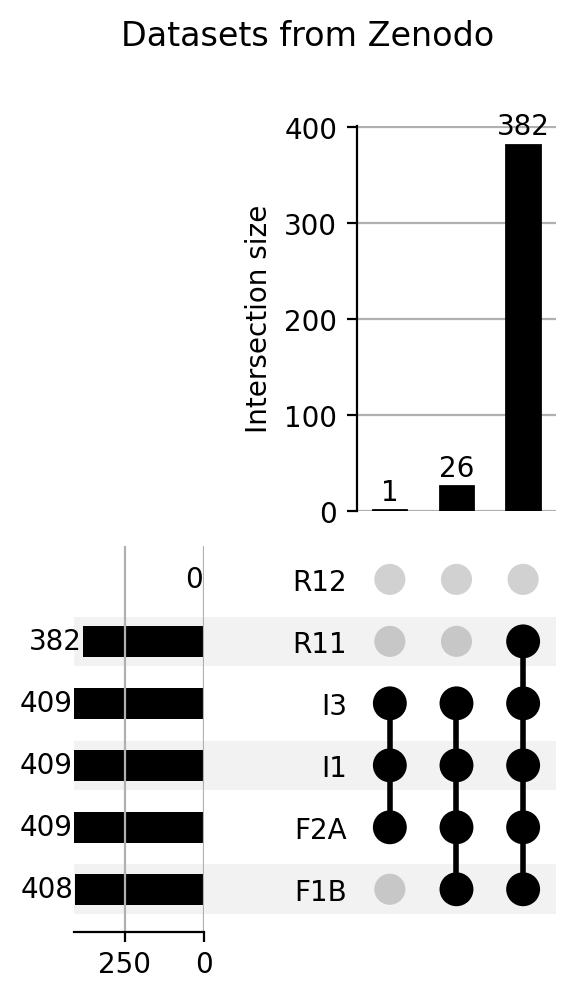

In [16]:
upset = UpSet(df_upset, subset_size='count', show_counts=True, sort_categories_by=None, orientation='horizontal')

#upset.style_subsets(present=["with_exome", "with_images"],
#                    facecolor="red")

params = {'legend.fontsize': 8}
with plt.rc_context(params):
    upset.plot()
plt.suptitle("Datasets from Zenodo")
plt.savefig(OUTPUT_DIR + 'zenodo-no-F2B-no-R13_data.png', format="png")
plt.show()